Name : Gandluru Mohammed Yaseen  
Reg.No : 12409548  
M.Tech specialized in AI and ML  
Lovely Professional University  
Mobile: 8328377285  
mail : gandlurumohammedyaseen@gmail.com  
LinkedIn: [yaseeng-md](https://www.linkedin.com/in/yaseeng-md/)  
GitHub: [yaseeng-md](http://www.github.com/yaseeng-md)


# Install Libraries and Import them 

#### Install Librabries using pip

In [2]:
!pip install -q transformers evaluate datasets jiwer

#### Import libraries

In [ ]:
# Standard libraries
import os

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from PIL import Image
from sklearn.model_selection import train_test_split

# Kaggle & logging
import wandb
from kaggle_secrets import UserSecretsClient

# PyTorch
import torch
from torch.utils.data import Dataset

# Hugging Face
from evaluate import load
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator, Seq2SeqTrainer, Seq2SeqTrainingArguments

In [1]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass
print(os.path.join(dirname, filename))

/kaggle/input/iam-trocr/IAM/image/d04-037-00.jpg


# Dataset Creation

In [4]:
import pandas as pd

df = pd.read_fwf('/kaggle/input/iam-trocr/IAM/gt_test.txt', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
del df[2]
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...
1,c04-110-01.jpg,"assuredness "" Bella Bella Marie "" ( Parlophone..."
2,c04-110-02.jpg,I don't think he will storm the charts with th...
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-..."
4,c04-116-00.jpg,He is also a director of a couple of garages ....


#### Split the dataset into Training and Testing 

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

#### Custom Dataset Creation class using torch.Datasets

In [6]:
class IAMDataset(Dataset):
    
    """
    A custom PyTorch Dataset for OCR fine-tuning using the IAM Handwriting dataset (or similar).
    
    This dataset class loads images and their corresponding text labels, processes them using
    a TrOCRProcessor (from Hugging Face), and returns the required inputs for training a 
    VisionEncoderDecoderModel such as TrOCR.
    
    Args:
        root_dir (str): Path to the directory containing image files.
        df (pd.DataFrame): DataFrame with two columns: 
                           'file_name' (relative image path) and 'text' (ground-truth transcription).
        processor (TrOCRProcessor): Processor for both image and text (handles feature extraction & tokenization).
        max_target_length (int): Maximum length for tokenized text labels. Default is 128.
    """
    
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

#### Use the Instance and Preprocess the dataset according to TrOCR

In [7]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
train_dataset = IAMDataset(root_dir='/kaggle/input/iam-trocr/IAM/image/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/kaggle/input/iam-trocr/IAM/image/',
                           df=test_df,
                           processor=processor)

2025-05-16 06:36:13.733437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747377373.926162      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747377373.983235      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

# Model Training

#### Define Model

In [8]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,
  "d_

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Set model Parameters and Cofigarations

In [9]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    predict_with_generate=True,
    eval_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,                  
    num_train_epochs=10,                 
    fp16=True,
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)


#### Define the required Metrics

In [11]:
cer_metric = load("cer")
wer_metric = load("wer")

In [12]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}


#### Login into wandb.ai

In [13]:
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gandlurumohammedyaseen (gandlurumohammedyaseen-lovely-professional-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### Compile the model trainer

In [14]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/tmp/ipykernel_35/2936316434.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Cer,Wer
200,2.720700,3.284099,0.502517,0.657556
400,1.166900,2.197404,0.460570,0.625146
600,1.258800,1.938377,0.498482,0.654432
800,0.635800,1.763478,0.501119,0.658141
1000,0.455100,1.726363,0.477349,0.630223
1200,0.624600,1.672589,0.466603,0.614799
1400,0.529000,1.603672,0.493129,0.640180
1600,0.405700,1.479471,0.493568,0.636861
1800,0.157000,1.380923,0.485099,0.637251
2000,0.196400,1.441660,0.473594,0.611480


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=2920, training_loss=0.879230626709823, metrics={'train_runtime': 10193.9153, 'train_samples_per_second': 2.288, 'train_steps_per_second': 0.286, 'total_flos': 3.1333599936679772e+19, 'train_loss': 0.879230626709823, 'epoch': 10.0})

# Testing Model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=1024, out_features=4096, bias=True)
    

In [17]:
# Load and preprocess the image
image_path = "/kaggle/input/iam-trocr/IAM/image/d04-037-00.jpg"
image = Image.open(image_path).convert("RGB")

# Resize and normalize as expected by TrOCR
pixel_values = processor(images=image, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)


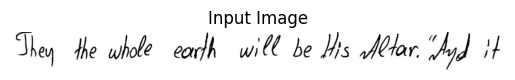

Predicted Text: Then whole earth be will Hisar " it it


In [20]:
# Generate prediction
with torch.no_grad():
    generated_ids = model.generate(pixel_values)

plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

# Decode prediction
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Predicted Text:", predicted_text)
